In [1]:
import pandas as pd
pd.options.display.max_rows = 999
import numpy as np
from scipy import stats
from scipy.stats import chisquare, chi2_contingency
from sklearn.feature_selection import f_classif, chi2
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
import pickle
%matplotlib inline

In [2]:
df = pd.read_pickle('../data/interim/train_clean.pickle')
df.head()

,ProductName,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,...,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections,AvSigVersion_extracted,AppVersion_extracted,EngineVersion_extracted,OsVer_encoded,Census_OSBranch_release_extracted,IsProtected_encoded,RAM_bins
0,win8defender,7.0,0,53447.0,1.0,1.0,1,29,128035.0,18.0,...,0,10.0,0,273,18,15100,10.0,rs4_release,2.0,4-8 GB
1,win8defender,7.0,0,53447.0,1.0,1.0,1,93,1482.0,18.0,...,0,8.0,0,263,13,14600,10.0,rs4_release,2.0,4-8 GB
2,win8defender,7.0,0,53447.0,1.0,1.0,1,86,153579.0,18.0,...,0,3.0,0,273,18,15100,10.0,rs4_release,2.0,4-8 GB
3,win8defender,7.0,0,53447.0,1.0,1.0,1,88,20710.0,NaN,...,0,3.0,1,273,18,15100,10.0,rs4_release,2.0,4-8 GB
4,win8defender,7.0,0,53447.0,1.0,1.0,1,18,37376.0,NaN,...,0,1.0,1,273,18,15100,10.0,rs4_release,2.0,4-8 GB


In [3]:
df.shape

(8921483, 72)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8921483 entries, 0 to 8921482
Data columns (total 72 columns):
 #   Column                                             Dtype   
---  ------                                             -----   
 0   ProductName                                        category
 1   RtpStateBitfield                                   category
 2   IsSxsPassiveMode                                   Int64   
 3   AVProductStatesIdentifier                          category
 4   AVProductsInstalled                                category
 5   AVProductsEnabled                                  category
 6   HasTpm                                             Int64   
 7   CountryIdentifier                                  category
 8   CityIdentifier                                     category
 9   OrganizationIdentifier                             category
 10  GeoNameIdentifier                                  category
 11  LocaleEnglishNameIdentifier          

In [5]:
cat_col = df.select_dtypes('category').columns.tolist()
binary_col = df.select_dtypes('Int64').columns.tolist()
num_col = [col for col in df.columns 
           if col not in cat_col
           if col not in binary_col]

## Numerical data

**Univariate Analysis**

In [6]:
df[num_col].head(10)

,Census_ProcessorCoreCount,Census_PrimaryDiskTotalCapacity,Census_SystemVolumeTotalCapacity,Census_TotalPhysicalRAM,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_InternalBatteryNumberOfCharges
0,4.0,476940.0,299451.0,4096.0,18.900000,1440.0,900.0,4.294967e+09
1,4.0,476940.0,102385.0,4096.0,13.900000,1366.0,768.0,1.000000e+00
2,4.0,114473.0,113907.0,4096.0,21.500000,1920.0,1080.0,4.294967e+09
3,4.0,238475.0,227116.0,4096.0,18.500000,1366.0,768.0,4.294967e+09
4,4.0,476940.0,101900.0,6144.0,14.000000,1366.0,768.0,0.000000e+00
5,2.0,114473.0,113671.0,8192.0,21.500000,1920.0,1080.0,4.294967e+09
6,2.0,476940.0,458702.0,4096.0,17.200001,1600.0,900.0,0.000000e+00
7,2.0,305245.0,290807.0,4096.0,15.500000,1366.0,768.0,0.000000e+00
8,4.0,305245.0,303892.0,4096.0,15.600000,1920.0,1080.0,0.000000e+00
9,4.0,953869.0,203252.0,8192.0,15.500000,1366.0,768.0,0.000000e+00


In [7]:
df[num_col].describe().T

,count,mean,std,min,25%,50%,75%,max
Census_ProcessorCoreCount,8880177.0,3.989696e+00,2.082553e+00,1.0,2.0,4.0,4.000000e+00,1.920000e+02
Census_PrimaryDiskTotalCapacity,8868431.0,5.129776e+05,3.564779e+05,0.0,239372.0,476940.0,9.538690e+05,1.526074e+07
Census_SystemVolumeTotalCapacity,8864221.0,3.761297e+05,3.187795e+05,0.0,120775.0,249497.0,4.759700e+05,2.000000e+06
Census_TotalPhysicalRAM,8840950.0,6.115257e+03,5.115821e+03,255.0,4096.0,4096.0,8.192000e+03,1.572864e+06
Census_InternalPrimaryDiagonalDisplaySizeInInches,8874349.0,1.667620e+01,5.892932e+00,0.7,13.9,15.5,1.720000e+01,1.823000e+02
Census_InternalPrimaryDisplayResolutionHorizontal,8874341.0,1.547743e+03,3.683176e+02,144.0,1366.0,1366.0,1.920000e+03,1.228800e+04
Census_InternalPrimaryDisplayResolutionVertical,8874341.0,8.975861e+02,2.145927e+02,171.0,768.0,768.0,1.080000e+03,8.640000e+03
Census_InternalBatteryNumberOfCharges,8652728.0,1.123782e+09,1.887782e+09,0.0,0.0,0.0,4.294967e+09,4.294967e+09


Census_InternalPrimaryDiagonalDisplaySizeInInches is continuous, the other variables are discrete, however we may treat them as continuous given the number of counts and dimension of dataset.

**Census_InternalPrimaryDiagonalDisplaySizeInInches**

In [8]:
def cont_var_subplots(var_name, df, xlabel, figsize=(16, 6), log_scale=False):
    
    """
    Plots the boxplot and histogram of var_name (string)
    in a pandas df and sets the x label to xlabel (string).
    """
    
    fig, axes = plt.subplots(2, 1, figsize=figsize, sharex=True)
    sns.boxplot(ax=axes[0], x=var_name, data=df)
    axes[0].set_xlabel('')
    sns.histplot(ax=axes[1], x=var_name, data=df, bins=100)
    axes[1].set_xlabel(xlabel)
    if log_scale:
        axes[0].set(xscale="log")
        axes[1].set(xscale="log")

    plt.tight_layout()

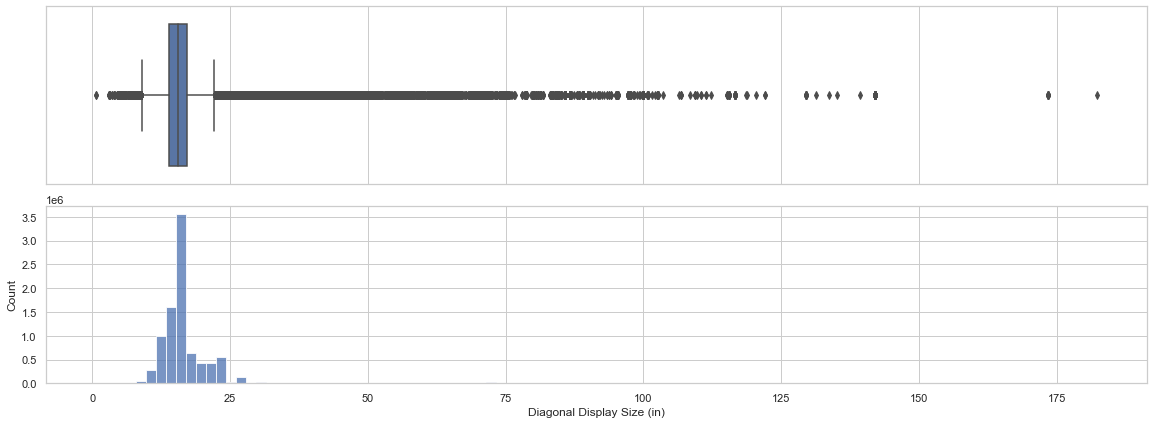

In [9]:
cont_var_subplots('Census_InternalPrimaryDiagonalDisplaySizeInInches', df, 'Diagonal Display Size (in)')

Outlier will be removed based on Z-score.

In [10]:
outlier_list = ['Census_InternalPrimaryDiagonalDisplaySizeInInches']

**Census_ProcessorCoreCount**

In [11]:
df['Census_ProcessorCoreCount'].nunique()

45

In [12]:
CoreCount_prob = pd.DataFrame(df['Census_ProcessorCoreCount'].value_counts(normalize=True)).reset_index()    
CoreCount_prob.columns = ['Core', 'Probability']
CoreCount_HasDetections_prob = df.groupby('Census_ProcessorCoreCount')['HasDetections'].mean().reset_index()
CoreCount_HasDetections_prob.columns = ['Core', 'HasDetections']
CoreCount_HasDetections_prob.head()

,Core,HasDetections
0,1.0,0.295042
1,2.0,0.459875
2,3.0,0.456038
3,4.0,0.507915
4,5.0,0.458333


In [13]:
CoreCount_prob = CoreCount_prob.merge(CoreCount_HasDetections_prob,  
                     left_on='Core',
                     right_on='Core')
CoreCount_prob.Core = CoreCount_prob.Core.astype('int')

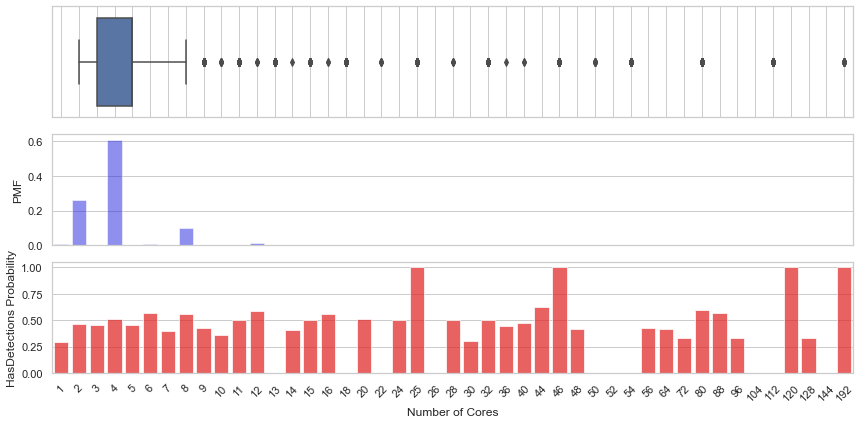

In [14]:
fig, axes = plt.subplots(3, 1, figsize=(12, 6), sharex=True)

sns.boxplot(ax=axes[0],
             x='Census_ProcessorCoreCount', 
             data=df)
axes[0].set_xlabel('');

sns.barplot(ax=axes[1],
            x='Core', 
            y='Probability',
            data=CoreCount_prob,
            color='blue',
            alpha=0.5)
axes[1].set_xlabel('')
axes[1].set_ylabel('PMF')

sns.barplot(ax=axes[2],
            x='Core', 
            y='HasDetections',
            data=CoreCount_prob,
            color='red',
            alpha=0.7)
axes[2].set_xlabel('Number of Cores');
axes[2].set_ylabel('HasDetections Probability')
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45, horizontalalignment='center')
plt.tight_layout()

In [15]:
outlier_list.append('Census_ProcessorCoreCount')

**Census_PrimaryDiskTotalCapacity**

In [16]:
df.Census_PrimaryDiskTotalCapacity.nunique()

5707

In [17]:
df.Census_PrimaryDiskTotalCapacity.value_counts().iloc[:30]

476940.0     2841530
953869.0     2175780
305245.0      474616
122104.0      469060
244198.0      452284
238475.0      312093
29820.0       303493
114473.0      259542
715404.0      245946
228936.0      159491
152627.0      117362
1907729.0      98160
488386.0       96985
59640.0        95669
29824.0        88731
610480.0       84850
29600.0        43855
76319.0        27882
457862.0       25321
59648.0        21240
119276.0       19967
114480.0       18888
61057.0        18379
239372.0       16983
29184.0        16183
476938.0       15611
228944.0       15259
115712.0       14021
57241.0        12829
61440.0        12358
Name: Census_PrimaryDiskTotalCapacity, dtype: int64

I will treat this as a continuous variable.

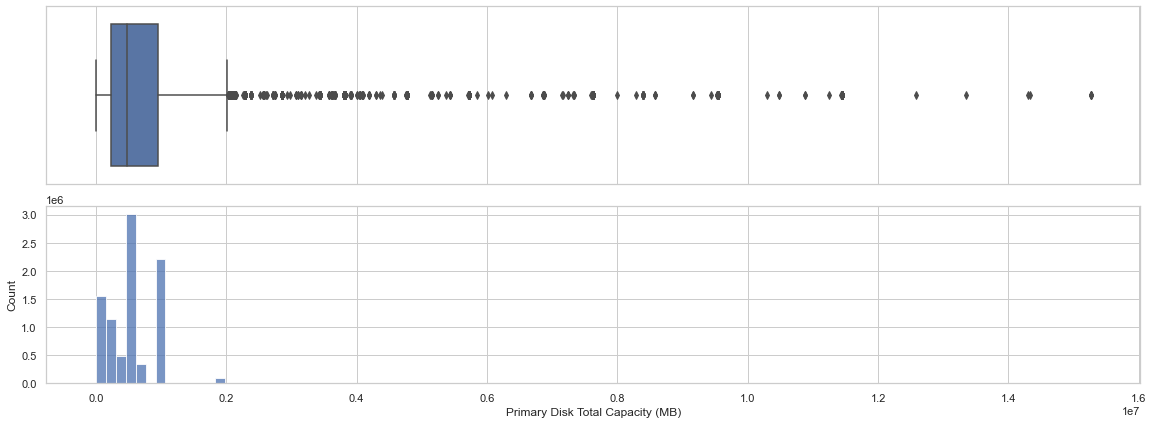

In [18]:
cont_var_subplots('Census_PrimaryDiskTotalCapacity', df, 'Primary Disk Total Capacity (MB)')

Outlier will be removed based on Z-score.

In [19]:
outlier_list.append('Census_PrimaryDiskTotalCapacity') 

**Census_SystemVolumeTotalCapacity**

In [20]:
df.Census_SystemVolumeTotalCapacity.nunique()

535313

In [21]:
df.Census_SystemVolumeTotalCapacity.value_counts().iloc[:30]

28542.0     51998
926992.0    50430
476389.0    44435
953253.0    41572
102400.0    41257
476324.0    40925
952728.0    38251
476323.0    35410
475799.0    33723
952727.0    33714
952792.0    32698
28558.0     31740
476438.0    30906
243582.0    28784
476373.0    27279
380772.0    26999
476388.0    26770
381546.0    26688
121488.0    26600
190001.0    26059
953318.0    25690
113922.0    25621
190774.0    25189
113857.0    23288
29043.0     23084
102401.0    21876
99500.0     21319
953093.0    21064
953302.0    20782
28557.0     20699
Name: Census_SystemVolumeTotalCapacity, dtype: int64

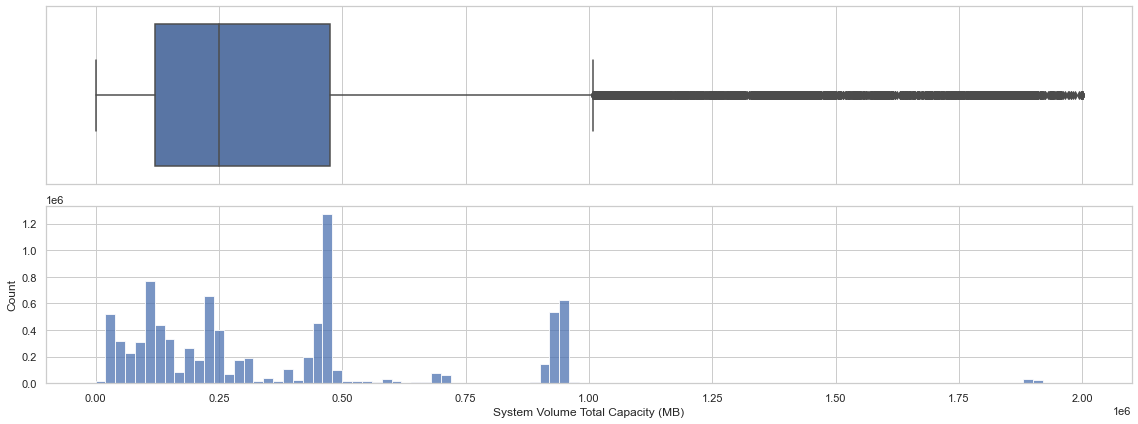

In [22]:
cont_var_subplots('Census_SystemVolumeTotalCapacity', df, 'System Volume Total Capacity (MB)')

I will treat this as a continuous variable.

Outlier will be removed based on Z-score.

In [23]:
outlier_list.append('Census_SystemVolumeTotalCapacity') 

**Census_TotalPhysicalRAM**

In [24]:
df.Census_TotalPhysicalRAM.nunique()

3446

In [25]:
df.Census_TotalPhysicalRAM.value_counts().iloc[:30]

4096.0      4094512
8192.0      2196505
2048.0      1097474
16384.0      531558
6144.0       398671
12288.0      159894
3072.0       152070
1024.0        66054
32768.0       58107
24576.0       11572
10240.0       10579
5120.0         7393
65536.0        6606
1536.0         4905
2560.0         4316
4095.0         4106
20480.0        3960
2047.0         3814
8191.0         1706
14336.0        1513
7168.0         1425
49152.0        1028
131072.0        936
3071.0          780
3584.0          714
18432.0         600
9216.0          551
6143.0          350
28672.0         317
3583.0          313
Name: Census_TotalPhysicalRAM, dtype: int64

I will treat this as a continuous variable.

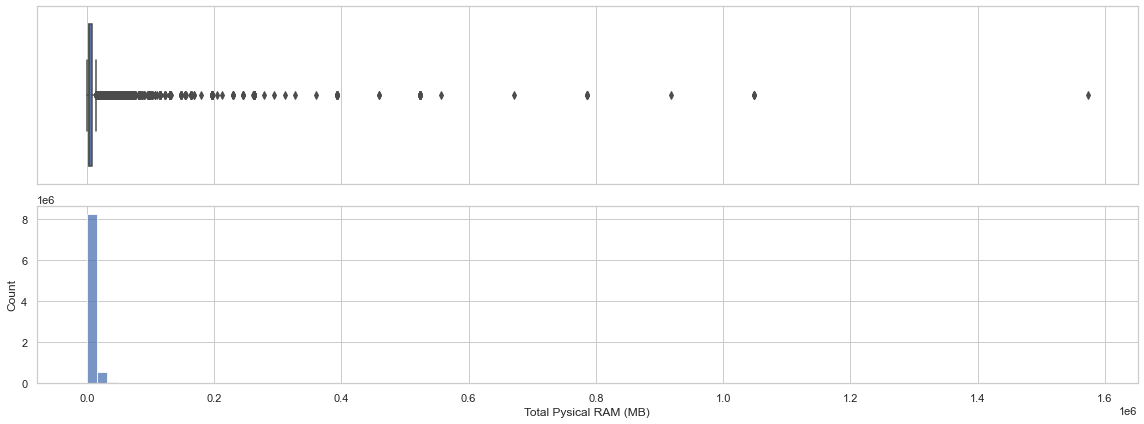

In [26]:
cont_var_subplots('Census_TotalPhysicalRAM', df, 'Total Pysical RAM (MB)')

Outlier will be removed based on Z-score.

In [27]:
outlier_list.append('Census_TotalPhysicalRAM')

**Census_InternalPrimaryDisplayResolutionHorizontal**

In [28]:
df.Census_InternalPrimaryDisplayResolutionHorizontal.nunique()

2179

In [29]:
df.Census_InternalPrimaryDisplayResolutionHorizontal.value_counts().iloc[:30]

1366.0    4515064
1920.0    2220648
1280.0     527430
1600.0     501288
1024.0     342620
1440.0     167131
1360.0     128010
1680.0     109716
2560.0      70120
2736.0      57640
3840.0      44668
800.0       31940
2160.0      31667
3200.0      17335
3000.0      11071
2880.0      10107
640.0        8796
1368.0       8398
1152.0       7784
2256.0       5470
3440.0       5269
2048.0       5028
1400.0       4263
1200.0       3484
1080.0       3288
768.0        3159
1768.0       2004
2304.0       1969
4096.0       1930
1800.0       1777
Name: Census_InternalPrimaryDisplayResolutionHorizontal, dtype: int64

I will treat this as a continuous variable.

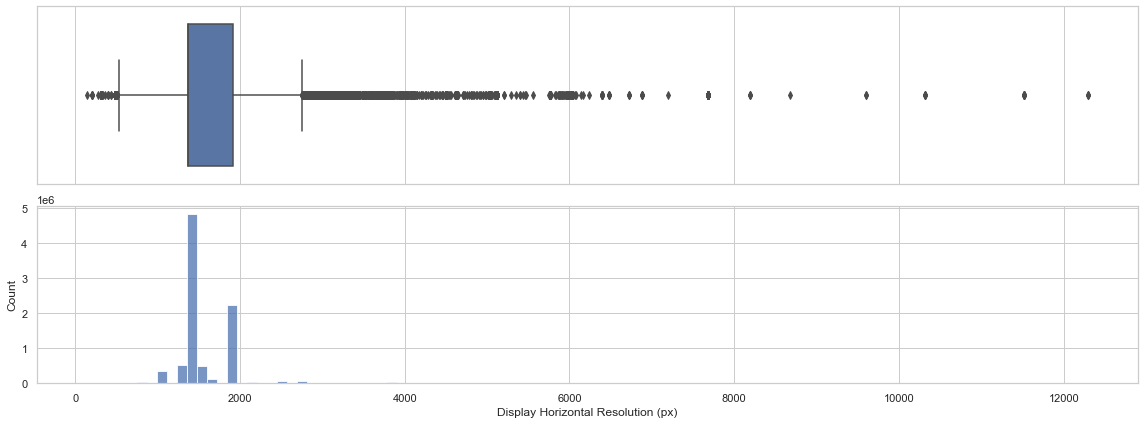

In [30]:
cont_var_subplots('Census_InternalPrimaryDisplayResolutionHorizontal', df, 'Display Horizontal Resolution (px)')

Outlier will be removed based on Z-score.

In [31]:
outlier_list.append('Census_InternalPrimaryDisplayResolutionHorizontal')

**Census_InternalPrimaryDisplayResolutionVertical**

In [32]:
df.Census_InternalPrimaryDisplayResolutionVertical.nunique()

1559

In [33]:
df.Census_InternalPrimaryDisplayResolutionVertical.value_counts().iloc[:30]

768.0     4973621
1080.0    2148402
900.0      655155
800.0      262058
1024.0     186322
1050.0     112220
1440.0      81251
1200.0      79397
600.0       63806
1824.0      57630
720.0       48483
2160.0      46777
1280.0      28870
1800.0      25532
1600.0      16009
2000.0      11066
480.0        8972
1920.0       8143
864.0        7550
960.0        6479
1504.0       5466
1152.0       2529
1536.0       2348
1366.0       2225
992.0        2018
1000.0       1641
2880.0       1588
945.0        1560
2736.0       1089
2100.0       1051
Name: Census_InternalPrimaryDisplayResolutionVertical, dtype: int64

I will treat this as a continuous variable.

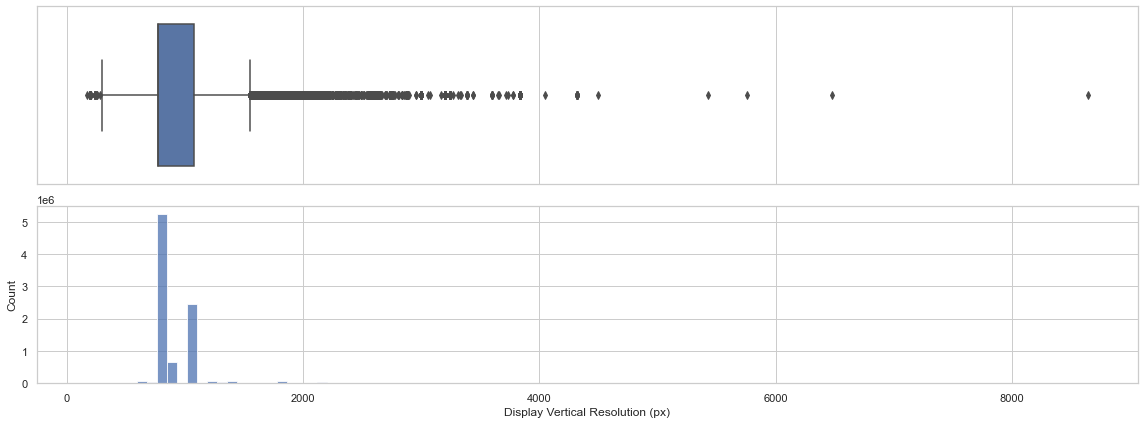

In [34]:
cont_var_subplots('Census_InternalPrimaryDisplayResolutionVertical', df, 'Display Vertical Resolution (px)')

Outlier will be removed based on Z-score.

In [35]:
outlier_list.append('Census_InternalPrimaryDisplayResolutionVertical')

**Census_InternalBatteryNumberOfCharges**

In [36]:
df.Census_InternalBatteryNumberOfCharges.nunique()

41087

In [37]:
df.Census_InternalBatteryNumberOfCharges.value_counts(normalize=True).iloc[:30]

0.000000e+00    0.584024
4.294967e+09    0.261651
1.000000e+00    0.006219
2.000000e+00    0.003251
1.600000e+01    0.003161
3.000000e+00    0.002489
3.300000e+01    0.002279
4.000000e+00    0.002083
5.000000e+00    0.001871
6.000000e+00    0.001673
7.000000e+00    0.001561
8.000000e+00    0.001501
9.000000e+00    0.001389
3.740000e+02    0.001344
1.000000e+01    0.001331
1.100000e+01    0.001281
4.380000e+02    0.001237
1.200000e+01    0.001221
1.300000e+01    0.001152
1.400000e+01    0.001133
3.770000e+02    0.001123
1.500000e+01    0.001112
2.560000e+02    0.001107
2.600000e+01    0.001068
1.700000e+01    0.001033
1.800000e+01    0.001019
3.840000e+02    0.001004
1.900000e+01    0.000979
2.000000e+01    0.000962
2.100000e+01    0.000947
Name: Census_InternalBatteryNumberOfCharges, dtype: float64

In [38]:
df.Census_InternalBatteryNumberOfCharges.max()

4294967300.0

<AxesSubplot:>

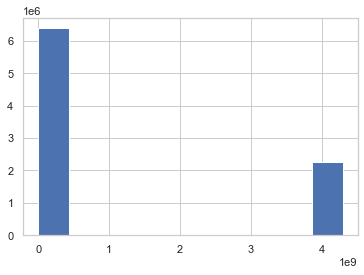

In [39]:
df.Census_InternalBatteryNumberOfCharges.hist()

In [40]:
int_battery_charge_contingency = pd.crosstab(df.Census_InternalBatteryNumberOfCharges, df.HasDetections)
int_battery_charge_contingency

HasDetections,0,1
Census_InternalBatteryNumberOfCharges,,
0.000000e+00,2541587,2511817
1.000000e+00,31203,22607
2.000000e+00,16455,11673
3.000000e+00,12580,8957
4.000000e+00,10615,7405
...,...,...
6.550900e+04,1,0
6.551600e+04,1,0
6.551900e+04,1,0


This might mean som values are missing (0's), others are actual values - even though small numbers like 1, 2, 3 .., and it seems caped to the max value of 4.3e9.

In [41]:
df.loc[df.Census_InternalBatteryNumberOfCharges == 0, 'Census_InternalBatteryNumberOfCharges'] = 0
df.loc[(df.Census_InternalBatteryNumberOfCharges != 0) &
       (df.Census_InternalBatteryNumberOfCharges != df.Census_InternalBatteryNumberOfCharges.max()), 
       'Census_InternalBatteryNumberOfCharges'] = 'Other'
df.Census_InternalBatteryNumberOfCharges = df.Census_InternalBatteryNumberOfCharges.map({0.0:'None',
                                                                                        4294967296.0: 'Max',
                                                                                        'Other':'Other'}).astype('category')
df.Census_InternalBatteryNumberOfCharges.value_counts()

None     5053404
Max      2263993
Other    1604086
Name: Census_InternalBatteryNumberOfCharges, dtype: int64

In [44]:
df.Census_InternalBatteryNumberOfCharges.dtype

CategoricalDtype(categories=['Max', 'None', 'Other'], ordered=False)

In [42]:
battery_charge_contingency = pd.crosstab(df.Census_InternalBatteryNumberOfCharges, df.HasDetections)
battery_charge_contingency

HasDetections,0,1
Census_InternalBatteryNumberOfCharges,,
Max,1096688,1167305
None,2541587,2511817
Other,824316,779770


In [43]:
chi2_contingency(battery_charge_contingency)

(3613.54117241781,
 0.0,
 2,
 array([[1132465.84518101, 1131527.15481899],
        [2527749.61402314, 2525654.38597686],
        [ 802375.54079585,  801710.45920415]]))

## Remove outliers

In [45]:
outlier_list

['Census_InternalPrimaryDiagonalDisplaySizeInInches',
 'Census_ProcessorCoreCount',
 'Census_PrimaryDiskTotalCapacity',
 'Census_SystemVolumeTotalCapacity',
 'Census_TotalPhysicalRAM',
 'Census_InternalPrimaryDisplayResolutionHorizontal',
 'Census_InternalPrimaryDisplayResolutionVertical']

In [46]:
z_score = np.abs(stats.zscore(df[outlier_list], nan_policy='omit'))
z_score

array([[0.37736872, 0.00494788, 0.10109194, ..., 0.39471024, 0.29252398,
        0.0112461 ],
       [0.4711053 , 0.00494788, 0.10109194, ..., 0.39471024, 0.4934376 ,
        0.60387266],
       [0.81857526, 0.00494788, 1.117893  , ..., 0.39471024, 1.0106995 ,
        0.85004437],
       ...,
       [0.19959356, 1.9256675 , 0.7539853 , ..., 0.4059436 , 1.0106995 ,
        0.85004437],
       [0.67473906, 0.95541185, 0.10109194, ..., 0.39471024, 1.4219843 ,
        0.60387266],
       [0.19959356, 0.00494788, 1.2368006 , ..., 0.00561667, 1.0106995 ,
        0.85004437]], dtype=float32)

In [47]:
sum(z_score>3)/df.shape[0]*100

array([1.22248734, 1.33069805, 1.23296766, 0.78336752, 0.90009699,
       1.72831131, 1.95568383])

In [48]:
outlier_indices = df[outlier_list][z_score > 3].index
outlier_indices

Int64Index([     18,      21,      34,      34,      35,      49,      63,
                 79,      79,      87,
            ...
            8921400, 8921405, 8921405, 8921420, 8921425, 8921425, 8921444,
            8921444, 8921444, 8921476],
           dtype='int64', length=816638)

In [49]:
clean_df = df.iloc[~df.index.isin(outlier_indices), :]
clean_df.shape

(8395341, 72)

In [50]:
clean_df[outlier_list].isnull().sum()

Census_InternalPrimaryDiagonalDisplaySizeInInches    45442
Census_ProcessorCoreCount                            39731
Census_PrimaryDiskTotalCapacity                      50415
Census_SystemVolumeTotalCapacity                     50389
Census_TotalPhysicalRAM                              76593
Census_InternalPrimaryDisplayResolutionHorizontal    45450
Census_InternalPrimaryDisplayResolutionVertical      45450
dtype: int64

In [51]:
cat_col = clean_df.select_dtypes('category').columns.tolist()
binary_col = clean_df.select_dtypes('Int64').columns.tolist()
num_col = [col for col in clean_df.columns 
           if col not in cat_col
           if col not in binary_col]

**Multivariate Analysis**

In [52]:
num_col + binary_col

['Census_ProcessorCoreCount',
 'Census_PrimaryDiskTotalCapacity',
 'Census_SystemVolumeTotalCapacity',
 'Census_TotalPhysicalRAM',
 'Census_InternalPrimaryDiagonalDisplaySizeInInches',
 'Census_InternalPrimaryDisplayResolutionHorizontal',
 'Census_InternalPrimaryDisplayResolutionVertical',
 'IsSxsPassiveMode',
 'HasTpm',
 'AutoSampleOptIn',
 'SMode',
 'Firewall',
 'Census_HasOpticalDiskDrive',
 'Census_IsPortableOperatingSystem',
 'Census_IsFlightsDisabled',
 'Census_IsSecureBootEnabled',
 'Census_IsVirtualDevice',
 'Census_IsTouchEnabled',
 'Census_IsPenCapable',
 'Census_IsAlwaysOnAlwaysConnectedCapable',
 'Wdft_IsGamer',
 'HasDetections']

In [53]:
num_col_name_dict = {'Census_PrimaryDiskTotalCapacity':'Disk Capacity (MB)',
                     'Census_SystemVolumeTotalCapacity':'System Capacity (MB)',
                     'Census_TotalPhysicalRAM': 'RAM (MB)',
                     'Census_InternalPrimaryDiagonalDisplaySizeInInches':'Display Size (in)',
                     'Census_InternalPrimaryDisplayResolutionHorizontal':'Horizontal Resolution (px)',
                     'Census_InternalPrimaryDisplayResolutionVertical':'Vertical Resolution (px)',
                     }
bin_col_name_dict = {'IsSxsPassiveMode':'Passive Mode',
                     'HasTpm':'Tpm',
                     'AutoSampleOptIn':'Auto Sample',
                     'SMode':'SMode',
                     'Firewall':'Firewall',
                     'Census_HasOpticalDiskDrive':'Optical Disk Drive',
                     'Census_IsPortableOperatingSystem':'Portable OS',
                     'Census_IsFlightsDisabled':'Flights Disabled',
                     'Census_IsSecureBootEnabled':'Secure Boot',
                     'Census_IsVirtualDevice':'Virtual Device',
                     'Census_IsTouchEnabled':'Touch Enabled',
                     'Census_IsPenCapable':'Pen Capable',
                     'Census_IsAlwaysOnAlwaysConnectedCapable':'Always Connected Capable',
                     'Wdft_IsGamer':'Gamer',
                     'HasDetections':'HasDetections',
                     'IsProtected_encoded':'Protected'}

KeyboardInterrupt: 

<Figure size 1080x1080 with 0 Axes>

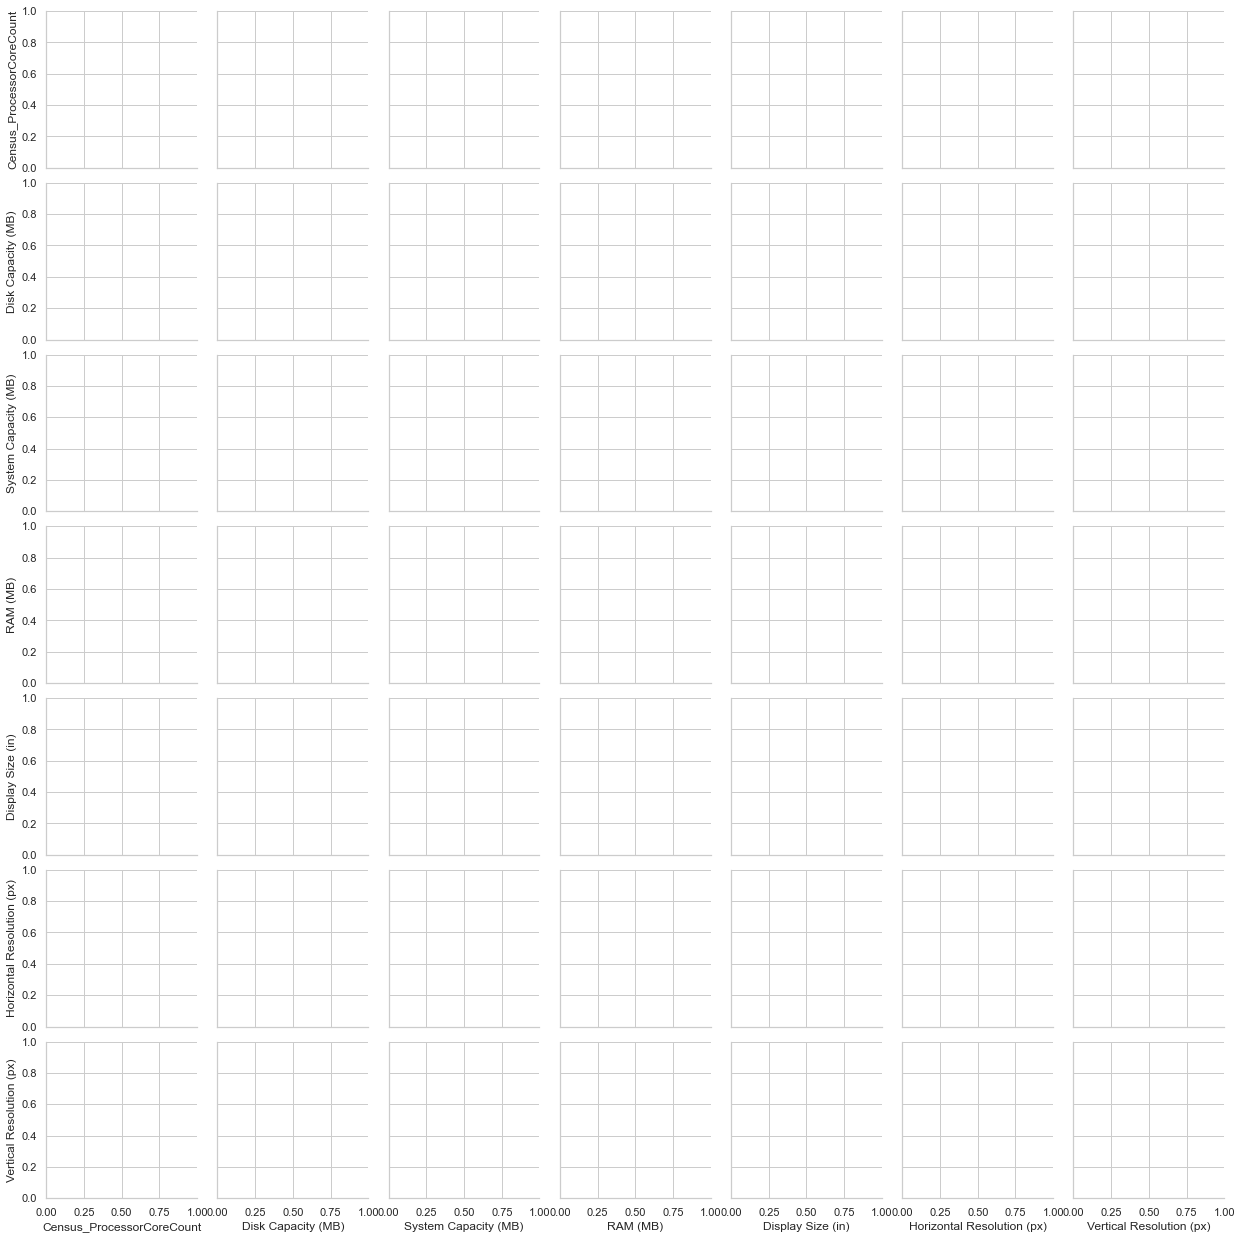

In [54]:
df_sample = clean_df[num_col+['HasDetections']].rename(columns=num_col_name_dict).sample(frac=0.01)
plt.figure(figsize=(15,15))
sns.pairplot(df_sample, hue='HasDetections', kind='reg', plot_kws={ 'scatter_kws': {'alpha': 0.1}})
plt.subplots_adjust(hspace=.2, wspace=.2)
plt.tight_layout();

In [ ]:
m = df['Census_PrimaryDiskTotalCapacity'].mean()
s = df['Census_PrimaryDiskTotalCapacity'].std()
x = np.random.normal(m, s, clean_df.shape[0])
y = clean_df['Census_PrimaryDiskTotalCapacity']
data = pd.DataFrame({'x':x, 'y':y})
from seaborn_qqplot import pplot
pplot(x='x', y='y', data=data, kind='qq');

In [ ]:
corr_matrix = clean_df[num_col+['HasDetections']].rename(columns=num_col_name_dict).corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
f, ax = plt.subplots(figsize=(6,6))
sns.heatmap(corr_matrix, vmin=-1, vmax=1, mask=mask, cmap=cmap, 
            square=True, linewidths=.5, cbar_kws={"shrink": .7})

In [ ]:
corr_matrix = clean_df[num_col+['HasDetections']].rename(columns=num_col_name_dict).corr('spearman')
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
f, ax = plt.subplots(figsize=(6,6))
sns.heatmap(corr_matrix, vmin=-1, vmax=1, mask=mask, cmap=cmap, 
            square=True, linewidths=.5, cbar_kws={"shrink": .7})

As axpected the vertical and horizontal resolutions are correlated. Also the disk capacity and system capacity as one is a fraction of the other.

Relationship with target (boxplots and t-test)

In [ ]:
for col in num_col:
    plt.figure(figsize=(4,6))
    sns.boxplot(x='HasDetections', y=col, data=clean_df)
    r, pval = stats.pointbiserialr(clean_df[col].dropna(), clean_df.loc[clean_df[col].dropna().index, 'HasDetections'])
    print(f'{col} Point biserial correlation coefficient: r={round(r,2)}, p-value={pval}.')

In [ ]:
#f_stat, p_val = f_classif(clean_df[num_col].dropna(), clean_df.loc[clean_df[num_col].dropna().index, 'HasDetections'])
#t_test = pd.DataFrame({'F-statistics':f_stat, 'p-value':p_val}, index=num_col)    
#t_test

### Binary features

In [ ]:
binary_df = clean_df[binary_col].copy().astype('float')

In [ ]:
for col in binary_col:
    if col != 'HasDetections':
        plt.figure(figsize=(8, 6))
        sns.countplot(x=col, hue='HasDetections', data=binary_df, alpha=.7)

IsSxsPassiveMode, SMode, Census_IsTouchEnabled, Census_IsAlwaysOnAlwaysConnectedCapable, Wdft_IsGamer show less detections for the positive class. 'Census_HasOpticalDiskDrive' has more detections for the positive class. The other features' classes are equally distribited among detection and no detection.  

In [ ]:
chi2_stat, p_val = chi2(clean_df[binary_col].dropna().astype('float'),
                        clean_df.loc[clean_df[binary_col].dropna().index, 'HasDetections'].astype('float'))
chi2_test = pd.DataFrame({'Chi2':chi2_stat, 'p-value':p_val}, index=binary_col)    
chi2_test.drop('HasDetections', axis=0).sort_values('Chi2', ascending=False)

## Categorical Features

In [55]:
cardinality = clean_df[cat_col].nunique().sort_values(ascending=False)
high_cardinality = cardinality[cardinality > 10].index
low_cardinality = cardinality[cardinality <= 10].index

In [56]:
for col in low_cardinality:
    print(f'Feature: {col} \nUnique Values Count: {clean_df[col].nunique()}\n')   

Feature: Census_FlightRing 
Unique Values Count: 10

Feature: Census_PowerPlatformRoleName 
Unique Values Count: 10

Feature: Census_OSInstallTypeName 
Unique Values Count: 9

Feature: OsPlatformSubRelease 
Unique Values Count: 9

Feature: SkuEdition 
Unique Values Count: 8

Feature: AVProductsInstalled 
Unique Values Count: 8

Feature: RtpStateBitfield 
Unique Values Count: 7

Feature: Census_ProcessorManufacturerIdentifier 
Unique Values Count: 7

Feature: AVProductsEnabled 
Unique Values Count: 6

Feature: Census_OSWUAutoUpdateOptionsName 
Unique Values Count: 6

Feature: Census_ActivationChannel 
Unique Values Count: 6

Feature: ProductName 
Unique Values Count: 6

Feature: RAM_bins 
Unique Values Count: 5

Feature: Census_GenuineStateName 
Unique Values Count: 5

Feature: Platform 
Unique Values Count: 4

Feature: Census_PrimaryDiskTypeName 
Unique Values Count: 4

Feature: Census_OSArchitecture 
Unique Values Count: 3

Feature: Census_InternalBatteryNumberOfCharges 
Unique Values

In [57]:
## barplots of categorical with

In [58]:
for col in high_cardinality:
    print(f'Feature: {col} \nUnique Values Count: {clean_df[col].nunique()}\n')   

Feature: Census_OEMModelIdentifier 
Unique Values Count: 168399

Feature: CityIdentifier 
Unique Values Count: 105411

Feature: Census_FirmwareVersionIdentifier 
Unique Values Count: 48139

Feature: AVProductStatesIdentifier 
Unique Values Count: 28241

Feature: Census_OEMNameIdentifier 
Unique Values Count: 3678

Feature: Census_ProcessorModelIdentifier 
Unique Values Count: 3262

Feature: Census_FirmwareManufacturerIdentifier 
Unique Values Count: 678

Feature: IeVerIdentifier 
Unique Values Count: 297

Feature: GeoNameIdentifier 
Unique Values Count: 291

Feature: Census_OSBuildRevision 
Unique Values Count: 280

Feature: LocaleEnglishNameIdentifier 
Unique Values Count: 252

Feature: CountryIdentifier 
Unique Values Count: 222

Feature: Census_OSUILocaleIdentifier 
Unique Values Count: 146

Feature: OsBuild 
Unique Values Count: 73

Feature: EngineVersion_extracted 
Unique Values Count: 63

Feature: AvSigVersion_extracted 
Unique Values Count: 51

Feature: Census_OSBranch_release_e

In [59]:
id_col = [col for col in cat_col if 'Identifier' in col]
id_col

['AVProductStatesIdentifier',
 'CountryIdentifier',
 'CityIdentifier',
 'OrganizationIdentifier',
 'GeoNameIdentifier',
 'LocaleEnglishNameIdentifier',
 'IeVerIdentifier',
 'Census_OEMNameIdentifier',
 'Census_OEMModelIdentifier',
 'Census_ProcessorManufacturerIdentifier',
 'Census_ProcessorModelIdentifier',
 'Census_OSInstallLanguageIdentifier',
 'Census_OSUILocaleIdentifier',
 'Census_FirmwareManufacturerIdentifier',
 'Census_FirmwareVersionIdentifier',
 'Wdft_RegionIdentifier']

These columns will be encoded with target encoding (mean encoding).
Let's implement roll-up on the others.

In [60]:
mean_encoding_list = id_col

In [61]:
[col for col in cat_col if 'Identifier' not in col if clean_df[col].nunique()>10]

['OsBuild',
 'OsSuite',
 'SmartScreen',
 'UacLuaenable',
 'Census_MDC2FormFactor',
 'Census_ChassisTypeName',
 'Census_OSBuildRevision',
 'Census_OSEdition',
 'Census_OSSkuName',
 'AvSigVersion_extracted',
 'AppVersion_extracted',
 'EngineVersion_extracted',
 'Census_OSBranch_release_extracted']

Let's perform roll up to reduce cardinality.

**OsBuild**

In [62]:
os_build = pd.concat([clean_df['OsBuild'].value_counts(), 
                      clean_df['OsBuild'].value_counts(normalize=True)*100], 
                      axis=1)
os_build.columns=['Count', '%']
os_build.head(10)

,Count,%
17134,3586679,42.722255
16299,2390955,28.479546
15063,748195,8.912026
14393,704699,8.393929
10586,401700,4.784797
10240,264207,3.147067
9600,189321,2.255072
7601,91065,1.084709
17692,2838,0.033804
17738,2093,0.024930


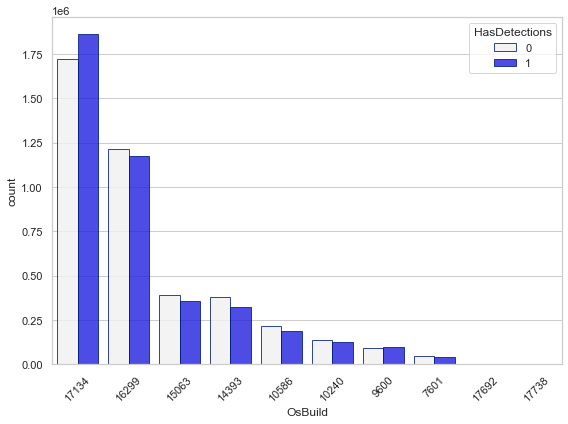

In [65]:
plt.figure(figsize=(8, 6))
sns.countplot(x='OsBuild',
            hue='HasDetections',
            data=clean_df,
            order = clean_df['OsBuild'].value_counts().index[:10],
            color='blue',
            edgecolor=sns.color_palette('dark', 1),
            alpha=0.8)
plt.legend(loc=1, title='HasDetections')
plt.xticks(rotation = 45)
plt.tight_layout()

In [66]:
clean_df['OsBuild'].dtype

CategoricalDtype(categories=[ 7600,  7601,  9600, 10240, 10586, 14393, 15063, 16299,
                  17133, 17134, 17604, 17618, 17623, 17627, 17634, 17639,
                  17643, 17650, 17655, 17661, 17666, 17672, 17677, 17682,
                  17686, 17689, 17692, 17694, 17704, 17711, 17713, 17718,
                  17723, 17725, 17728, 17730, 17733, 17734, 17735, 17738,
                  17740, 17741, 17744, 17746, 17747, 17749, 17750, 17751,
                  17752, 17753, 17754, 17755, 17756, 17757, 17758, 17759,
                  17760, 17761, 17763, 18201, 18204, 18214, 18219, 18224,
                  18226, 18227, 18230, 18233, 18234, 18236, 18237, 18238,
                  18240, 18241, 18242, 18244],
, ordered=False)

In [69]:
clean_df['OsBuild'] = clean_df['OsBuild'][clean_df['OsBuild'].notnull()].astype('str')
clean_df['OsBuild'].unique()

<ipython-input-69-7ed910747f83>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['OsBuild'] = clean_df['OsBuild'][clean_df['OsBuild'].notnull()].astype('str')


array(['17134', '14393', '16299', '7601', '9600', '15063', '10586',
       '10240', '17744', '17738', '17751', '17755', '17730', '17733',
       '17746', '17735', '17754', '17741', '17713', '17672', '17758',
       '17763', '7600', '17666', '17677', '17686', '17692', '17759',
       '17682', '17761', '17661', '17643', '17760', '18234', '17747',
       '18204', '17639', '17634', '18237', '18242', '17133', '17723',
       '17650', '17711', '17704', '18240', '17728', '17655', '18219',
       '18214', '17627', '18201', '17604', '17618', '17740', '18224',
       '18241', '17689', '17718', '17753', '18227', '18238', '17725',
       '17694', '17757', '18233', '17623', '17756', '17749', '17734',
       '17752', '18244', '17750'], dtype=object)

In [70]:
clean_df['OsBuild'] = clean_df['OsBuild'].astype('category')
clean_df['OsBuild'].cat.add_categories('Other', inplace=True)
clean_df.loc[(clean_df['OsBuild'] != '17134') & 
             (clean_df['OsBuild'] != '16299') &
             (clean_df['OsBuild'] != '15063') &
             (clean_df['OsBuild'] != '14393') &
             (clean_df['OsBuild'] != '10586') &
             (clean_df['OsBuild'] != '10240') &
             (clean_df['OsBuild'] != '9600') &
             (clean_df['OsBuild'] != '7601'),
             'OsBuild'] = 'Other'
clean_df['OsBuild'].cat.remove_unused_categories(inplace=True)
clean_df.rename(columns={'OsBuild':'OsBuild_encoded'}, inplace=True)
clean_df['OsBuild_encoded'].value_counts(normalize=True)

<ipython-input-70-d81c2c9dc59a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['OsBuild'] = clean_df['OsBuild'].astype('category')
C:\Users\marco\anaconda3\envs\capstone2env\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\marco\anaconda3\envs\capstone2env\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is

17134    0.427223
16299    0.284795
15063    0.089120
14393    0.083939
10586    0.047848
10240    0.031471
9600     0.022551
7601     0.010847
Other    0.002206
Name: OsBuild_encoded, dtype: float64

**OsSuite**

In [71]:
os_suite = pd.concat([clean_df['OsSuite'].value_counts(), 
                      clean_df['OsSuite'].value_counts(normalize=True)*100], 
                      axis=1)
os_suite.columns=['Count', '%']
os_suite.head(10)

,Count,%
768,5330433,63.492752
256,3055651,36.396985
272,7602,0.090550
400,536,0.006384
305,456,0.005432
16,414,0.004931
784,184,0.002192
274,24,0.000286
144,23,0.000274
49,14,0.000167


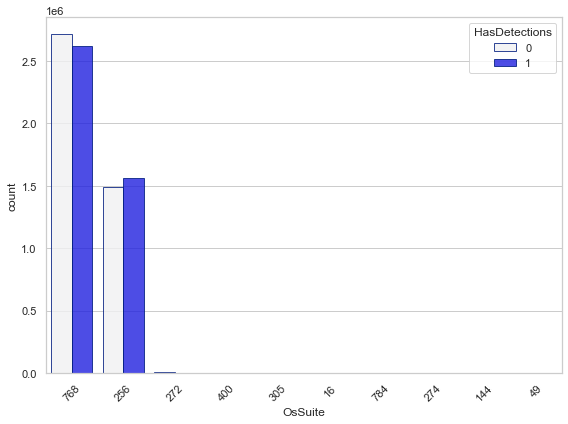

In [72]:
plt.figure(figsize=(8, 6))
sns.countplot(x='OsSuite',
            hue='HasDetections',
            data=clean_df,
            order = clean_df['OsSuite'].value_counts().index[:10],
            color='blue',
            edgecolor=sns.color_palette('dark', 1),
            alpha=0.8)
plt.legend(loc=1, title='HasDetections')
plt.xticks(rotation = 45)
plt.tight_layout()

In [73]:
clean_df['OsSuite'].dtype

CategoricalDtype(categories=[16, 18, 49, 144, 256, 272, 274, 305, 307, 400, 402, 528, 768,
                  784],
, ordered=False)

In [74]:
clean_df['OsSuite'] = clean_df['OsSuite'][clean_df['OsSuite'].notnull()].astype('str')
clean_df['OsSuite'].unique()

<ipython-input-74-799284c07b60>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['OsSuite'] = clean_df['OsSuite'][clean_df['OsSuite'].notnull()].astype('str')


array(['256', '768', '272', '400', '784', '305', '16', '274', '144', '49',
       '528', '307', '18'], dtype=object)

In [75]:
clean_df['OsSuite'] = clean_df['OsSuite'].astype('category')
clean_df['OsSuite'].cat.add_categories('Other', inplace=True)
clean_df.loc[(clean_df['OsSuite'] != '768') & 
             (clean_df['OsSuite'] != '256'),
             'OsSuite'] = 'Other'
clean_df['OsSuite'].cat.remove_unused_categories(inplace=True)
clean_df.rename(columns={'OsSuite':'OsSuite_encoded'}, inplace=True)
clean_df['OsSuite_encoded'].value_counts(normalize=True)

<ipython-input-75-5b5dfbe7d08e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['OsSuite'] = clean_df['OsSuite'].astype('category')
C:\Users\marco\anaconda3\envs\capstone2env\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\marco\anaconda3\envs\capstone2env\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is

768      0.634928
256      0.363970
Other    0.001103
Name: OsSuite_encoded, dtype: float64

**SmartScreen**

In [76]:
smart_screen = pd.concat([clean_df['SmartScreen'].value_counts(), 
                          clean_df['SmartScreen'].value_counts(normalize=True)*100],
                         axis=1)
smart_screen.columns=['Count', '%']
smart_screen.head(15)

,Count,%
RequireAdmin,4142850,75.364160
ExistsNotSet,1006222,18.304567
Off,170794,3.106979
Warn,123020,2.237904
Prompt,31566,0.574229
Block,21148,0.384711
On,800,0.014553
&#x02;,392,0.007131
&#x01;,311,0.005658
0,3,0.000055


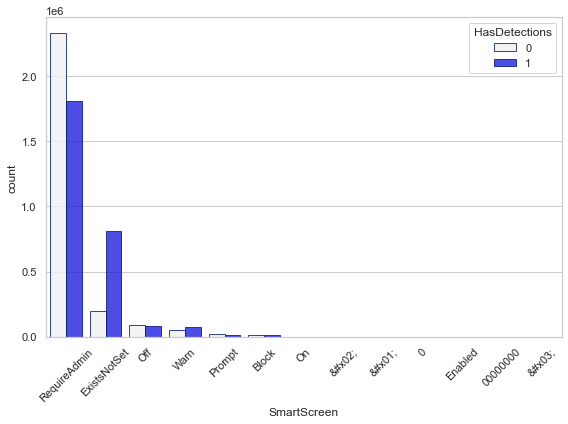

In [77]:
plt.figure(figsize=(8, 6))
sns.countplot(x='SmartScreen',
            hue='HasDetections',
            data=clean_df,
            order = clean_df['SmartScreen'].value_counts().index,
            color='blue',
            edgecolor=sns.color_palette('dark', 1),
            alpha=0.8)
plt.legend(loc=1, title='HasDetections')
plt.xticks(rotation = 45)
plt.tight_layout()

In [78]:
clean_df['SmartScreen'].dtype

CategoricalDtype(categories=['Block', 'ExistsNotSet', 'Off', 'On', 'Prompt',
                  'RequireAdmin', 'Warn', '&#x01;', '&#x02;', '0', 'Enabled',
                  '00000000', '&#x03;'],
, ordered=False)

In [79]:
clean_df['SmartScreen'].cat.add_categories('Other', inplace=True)
clean_df.loc[(clean_df['SmartScreen'] == '&#x02;') | 
             (clean_df['SmartScreen'] == '&#x01;') |
             (clean_df['SmartScreen'] == '&#x03;') |
             (clean_df['SmartScreen'] == '0') |
             (clean_df['SmartScreen'] == 'Enabled') |
             (clean_df['SmartScreen'] == '00000000'),
             'SmartScreen'] = 'Other'
clean_df['SmartScreen'].cat.remove_unused_categories(inplace=True)
clean_df.rename(columns={'SmartScreen':'SmartScreen_encoded'}, inplace=True)
clean_df['SmartScreen_encoded'].value_counts(normalize=True)

C:\Users\marco\anaconda3\envs\capstone2env\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\marco\anaconda3\envs\capstone2env\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
C:\Users\marco\anaconda3\envs\capstone2env\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

RequireAdmin    0.753642
ExistsNotSet    0.183046
Off             0.031070
Warn            0.022379
Prompt          0.005742
Block           0.003847
On              0.000146
Other           0.000129
Name: SmartScreen_encoded, dtype: float64

**UacLuaenable**

In [80]:
uac_luaenable = pd.concat([clean_df['UacLuaenable'].value_counts(), 
                          clean_df['UacLuaenable'].value_counts(normalize=True)*100],
                         axis=1)
uac_luaenable.columns=['Count', '%']
uac_luaenable.head(15)

,Count,%
1.0,8334964,99.404287
0.0,49685,0.592552
48.0,199,0.002373
2.0,29,0.000346
49.0,15,0.000179
6357062.0,13,0.000155
3.0,5,0.000060
5.0,1,0.000012
255.0,1,0.000012
7798884.0,1,0.000012


In [81]:
clean_df['UacLuaenable'].dtype

CategoricalDtype(categories=[0.0, 1.0, 2.0, 3.0, 5.0, 48.0, 49.0, 255.0, 6357062.0,
                  7798884.0, 16777216.0],
, ordered=False)

In [82]:
clean_df['UacLuaenable'] = clean_df['UacLuaenable'][clean_df['UacLuaenable'].notnull()].astype('str')
clean_df['UacLuaenable'].unique()

<ipython-input-82-112371dffe3e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['UacLuaenable'] = clean_df['UacLuaenable'][clean_df['UacLuaenable'].notnull()].astype('str')


array(['1.0', '0.0', nan, '48.0', '3.0', '2.0', '6357062.0', '49.0',
       '16777216.0', '255.0', '5.0', '7798884.0'], dtype=object)

In [83]:
clean_df['UacLuaenable'] = clean_df['UacLuaenable'].astype('category')
clean_df['UacLuaenable'].cat.add_categories('Other', inplace=True)
clean_df.loc[clean_df['UacLuaenable'] != '1.0', 'UacLuaenable'] = 'Other'
clean_df['UacLuaenable'].cat.remove_unused_categories(inplace=True)
clean_df.rename(columns={'UacLuaenable':'UacLuaenable_encoded'}, inplace=True)
clean_df['UacLuaenable_encoded'].value_counts(normalize=True)

<ipython-input-83-635d71ee09e2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['UacLuaenable'] = clean_df['UacLuaenable'].astype('category')
C:\Users\marco\anaconda3\envs\capstone2env\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\marco\anaconda3\envs\capstone2env\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_cat

1.0      0.992808
Other    0.007192
Name: UacLuaenable_encoded, dtype: float64

**Census_MDC2FormFactor**

In [84]:
mdc2 = pd.concat([clean_df['Census_MDC2FormFactor'].value_counts(), 
                          clean_df['Census_MDC2FormFactor'].value_counts(normalize=True)*100],
                         axis=1)
mdc2.columns=['Count', '%']
mdc2.head(15)

,Count,%
Notebook,5573978,66.393706
Desktop,1689186,20.120517
Convertible,384786,4.583328
AllInOne,277433,3.304607
Detachable,236642,2.818730
PCOther,134098,1.597291
LargeTablet,61574,0.733431
SmallTablet,29788,0.354816
SmallServer,5895,0.070218
MediumServer,1264,0.015056


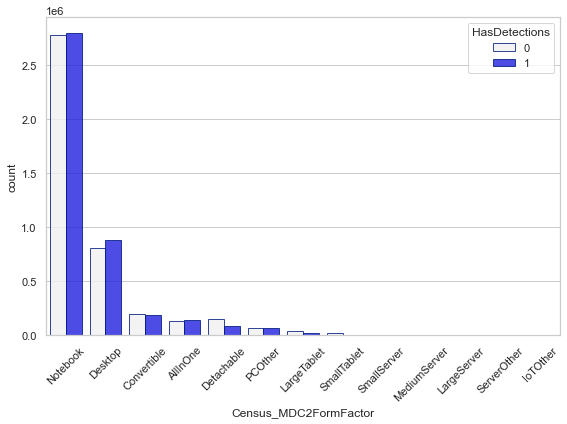

In [85]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Census_MDC2FormFactor',
            hue='HasDetections',
            data=clean_df,
            order = clean_df['Census_MDC2FormFactor'].value_counts().index,
            color='blue',
            edgecolor=sns.color_palette('dark', 1),
            alpha=0.8)
plt.legend(loc=1, title='HasDetections')
plt.xticks(rotation = 45)
plt.tight_layout()

In [86]:
clean_df['Census_MDC2FormFactor'].dtype

CategoricalDtype(categories=['AllInOne', 'Convertible', 'Desktop', 'Detachable',
                  'LargeServer', 'LargeTablet', 'MediumServer', 'Notebook',
                  'PCOther', 'SmallServer', 'SmallTablet', 'ServerOther',
                  'IoTOther'],
, ordered=False)

In [87]:
clean_df['Census_MDC2FormFactor'].cat.add_categories('Other', inplace=True)
clean_df.loc[(clean_df['Census_MDC2FormFactor'] == 'SmallServer') | 
             (clean_df['Census_MDC2FormFactor'] == 'MediumServer') |
             (clean_df['Census_MDC2FormFactor'] == 'LargeServer') |
             (clean_df['Census_MDC2FormFactor'] == 'ServerOther') |
             (clean_df['Census_MDC2FormFactor'] == 'IoTOther'),
             'Census_MDC2FormFactor'] = 'Other'
clean_df['Census_MDC2FormFactor'].cat.remove_unused_categories(inplace=True)
clean_df.rename(columns={'Census_MDC2FormFactor':'Census_MDC2FormFactor_encoded'}, inplace=True)
clean_df['Census_MDC2FormFactor_encoded'].value_counts(normalize=True)

C:\Users\marco\anaconda3\envs\capstone2env\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\marco\anaconda3\envs\capstone2env\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
C:\Users\marco\anaconda3\envs\capstone2env\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

Notebook       0.663937
Desktop        0.201205
Convertible    0.045833
AllInOne       0.033046
Detachable     0.028187
PCOther        0.015973
LargeTablet    0.007334
SmallTablet    0.003548
Other          0.000936
Name: Census_MDC2FormFactor_encoded, dtype: float64

**Census_ChassisTypeName**

In [88]:
census_chassis = pd.concat([clean_df['Census_ChassisTypeName'].value_counts(),
                            clean_df['Census_ChassisTypeName'].value_counts(normalize=True)*100],
                            axis=1)
census_chassis.columns=['Count', '%']
census_chassis.head(10)

,Count,%
Notebook,5126231,61.064805
Desktop,1626903,19.380031
Laptop,579720,6.905754
Portable,356299,4.244313
AllinOne,193725,2.307695
Convertible,78991,0.940958
MiniTower,78607,0.936384
Other,71852,0.855917
UNKNOWN,64727,0.771042
Detachable,49880,0.594182


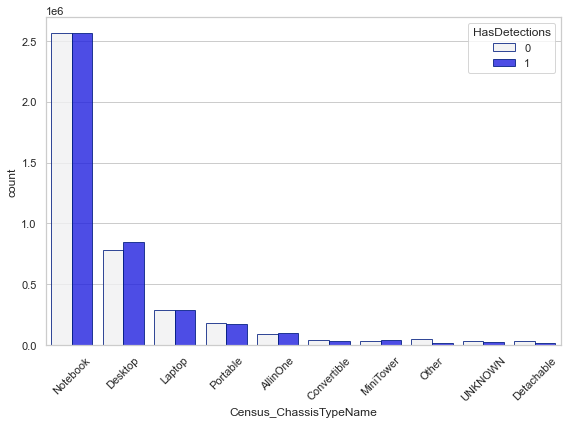

In [89]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Census_ChassisTypeName',
            hue='HasDetections',
            data=clean_df,
            order = clean_df['Census_ChassisTypeName'].value_counts().index[:10],
            color='blue',
            edgecolor=sns.color_palette('dark', 1),
            alpha=0.8)
plt.legend(loc=1, title='HasDetections')
plt.xticks(rotation = 45)
plt.tight_layout()

In [90]:
clean_df['Census_ChassisTypeName'].dtype

CategoricalDtype(categories=['30', 'AllinOne', 'Convertible', 'Desktop', 'Detachable',
                  'HandHeld', 'Laptop', 'LowProfileDesktop', 'LunchBox',
                  'MainServerChassis', 'MiniPC', 'MiniTower', 'Notebook',
                  'Other', 'Portable', 'RackMountChassis', 'SpaceSaving',
                  'StickPC', 'SubNotebook', 'Tablet', 'Tower', 'UNKNOWN',
                  'Unknown', 'BusExpansionChassis', '36', '82', '35', '0',
                  'Blade', 'IoTGateway', 'MultisystemChassis', 'SealedCasePC',
                  '32', '31', 'ExpansionChassis', 'SubChassis', 'PizzaBox',
                  '88', '25', '28', '44', '127', '76', 'DockingStation', '45',
                  '49', 'CompactPCI', '112', 'BladeEnclosure', '81',
                  'EmbeddedPC', '39'],
, ordered=False)

In [91]:
clean_df.loc[(clean_df['Census_ChassisTypeName'] != 'Notebook') &
             (clean_df['Census_ChassisTypeName'] != 'Desktop') &
             (clean_df['Census_ChassisTypeName'] != 'Laptop') &
             (clean_df['Census_ChassisTypeName'] != 'Portable') &
             (clean_df['Census_ChassisTypeName'] != 'AllinOne') &
             (clean_df['Census_ChassisTypeName'] != 'MiniTower') &
             (clean_df['Census_ChassisTypeName'] != 'Convertible'),
             'Census_ChassisTypeName'] = 'Other'
clean_df['Census_ChassisTypeName'].cat.remove_unused_categories(inplace=True)
clean_df.rename(columns={'Census_ChassisTypeName':'Census_ChassisTypeName_encoded'}, inplace=True)
clean_df['Census_ChassisTypeName_encoded'].value_counts(normalize=True)

C:\Users\marco\anaconda3\envs\capstone2env\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\marco\anaconda3\envs\capstone2env\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
C:\Users\marco\anaconda3\envs\capstone2env\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

Notebook       0.610604
Desktop        0.193786
Laptop         0.069053
Portable       0.042440
Other          0.042269
AllinOne       0.023075
Convertible    0.009409
MiniTower      0.009363
Name: Census_ChassisTypeName_encoded, dtype: float64

**Census_OSBuildRevision**

In [92]:
census_os_build_rev = pd.concat([clean_df['Census_OSBuildRevision'].value_counts(),
                                 clean_df['Census_OSBuildRevision'].value_counts(normalize=True)*100],
                                 axis=1)
census_os_build_rev.columns=['Count', '%']
census_os_build_rev.head(30)

,Count,%
228,1294304,15.416932
165,829665,9.882446
431,530450,6.318385
285,428386,5.102663
547,329957,3.930239
112,324845,3.869348
371,310808,3.702149
2189,216968,2.584386
125,204485,2.435696
191,204430,2.435041


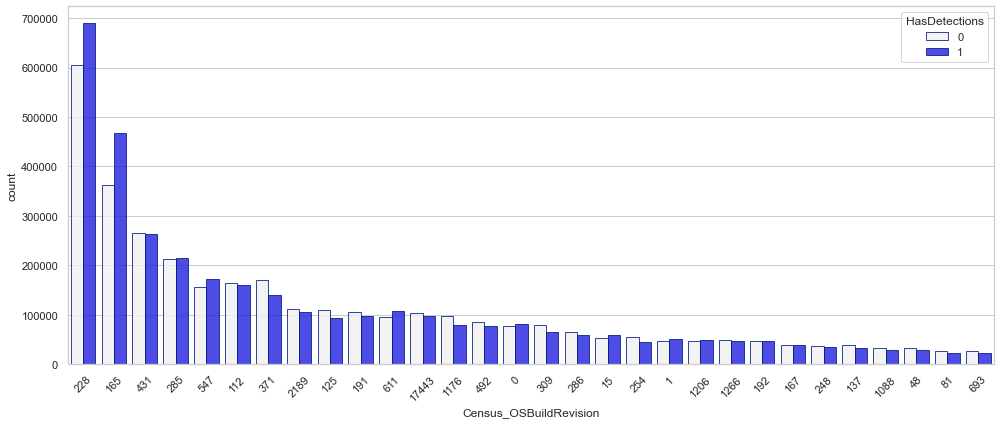

In [93]:
plt.figure(figsize=(14, 6))
sns.countplot(x='Census_OSBuildRevision',
            hue='HasDetections',
            data=clean_df,
            order = clean_df['Census_OSBuildRevision'].value_counts().index[:30],
            color='blue',
            edgecolor=sns.color_palette('dark', 1),
            alpha=0.8)
plt.legend(loc=1, title='HasDetections')
plt.xticks(rotation = 45)
plt.tight_layout()

In [94]:
clean_df['Census_OSBuildRevision'].dtype

CategoricalDtype(categories=[    0,     1,     3,     4,     5,    10,    11,    13,
                     14,    15,
                  ...
                  18756, 18778, 19069, 19102, 21703, 23418, 24149, 24214,
                  24241, 41736],
, ordered=False)

In [95]:
mean_encoding_list

['AVProductStatesIdentifier',
 'CountryIdentifier',
 'CityIdentifier',
 'OrganizationIdentifier',
 'GeoNameIdentifier',
 'LocaleEnglishNameIdentifier',
 'IeVerIdentifier',
 'Census_OEMNameIdentifier',
 'Census_OEMModelIdentifier',
 'Census_ProcessorManufacturerIdentifier',
 'Census_ProcessorModelIdentifier',
 'Census_OSInstallLanguageIdentifier',
 'Census_OSUILocaleIdentifier',
 'Census_FirmwareManufacturerIdentifier',
 'Census_FirmwareVersionIdentifier',
 'Wdft_RegionIdentifier']

In [96]:
mean_encoding_list.append('Census_OSBuildRevision')

**Census_OSEdition**

In [97]:
census_os_edition = pd.concat([clean_df['Census_OSEdition'].value_counts(),
                               clean_df['Census_OSEdition'].value_counts(normalize=True)*100], 
                              axis=1)
census_os_edition.columns=['Count', '%']
census_os_edition.head(30)

,Count,%
Core,3291667,39.208258
Professional,2852104,33.972462
CoreSingleLanguage,1901511,22.649598
CoreCountrySpecific,158038,1.882449
ProfessionalEducation,55946,0.666393
Education,34811,0.414647
Enterprise,34590,0.412014
ProfessionalN,26100,0.310887
EnterpriseS,18541,0.220849
Cloud,6269,0.074672


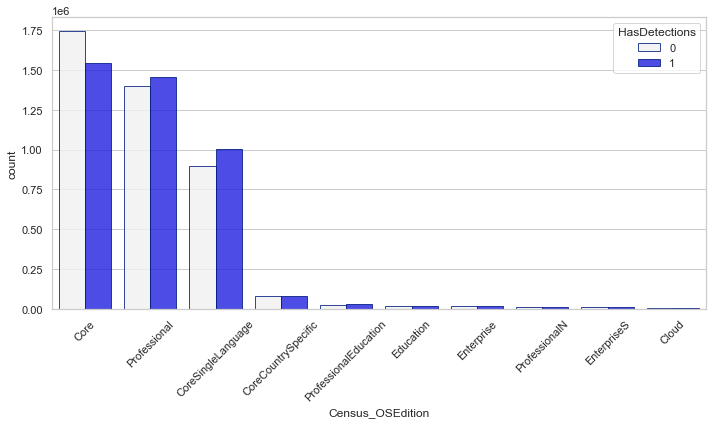

In [98]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Census_OSEdition',
            hue='HasDetections',
            data=clean_df,
            order = clean_df['Census_OSEdition'].value_counts().index[:10],
            color='blue',
            edgecolor=sns.color_palette('dark', 1),
            alpha=0.8)
plt.legend(loc=1, title='HasDetections')
plt.xticks(rotation = 45)
plt.tight_layout()

In [99]:
clean_df['Census_OSEdition'].dtype

CategoricalDtype(categories=['Cloud', 'Core', 'CoreCountrySpecific', 'CoreN',
                  'CoreSingleLanguage', 'Education', 'EducationN',
                  'Enterprise', 'EnterpriseS', 'EnterpriseSN', 'Professional',
                  'ProfessionalEducation', 'ProfessionalN', 'ServerStandard',
                  'ServerStandardEval', 'ServerDatacenterEval',
                  'ProfessionalEducationN', 'ServerSolution', 'EnterpriseN',
                  'ProfessionalWorkstationN', 'ProfessionalWorkstation',
                  'Ultimate', 'CloudN', 'ProfessionalCountrySpecific',
                  'ServerRdsh', 'ServerDatacenter', 'HomePremium',
                  'ProfessionalSingleLanguage', 'ServerDatacenterACor', 'Pro',
                  'Enterprise 2015 LTSB', 'Home'],
, ordered=False)

In [100]:
clean_df['Census_OSEdition'].cat.add_categories('Other', inplace=True)
other_os_edition = ~clean_df['Census_OSEdition'].isin(['Core',
                                                'Professional',
                                                'CoreSingleLanguage'])
clean_df.loc[other_os_edition, 'Census_OSEdition'] = 'Other'
clean_df['Census_OSEdition'].cat.remove_unused_categories(inplace=True)
clean_df.rename(columns={'Census_OSEdition':'Census_OSEdition_encoded'}, inplace=True)
clean_df['Census_OSEdition_encoded'].value_counts(normalize=True)

C:\Users\marco\anaconda3\envs\capstone2env\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\marco\anaconda3\envs\capstone2env\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
C:\Users\marco\anaconda3\envs\capstone2env\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

Core                  0.392083
Professional          0.339725
CoreSingleLanguage    0.226496
Other                 0.041697
Name: Census_OSEdition_encoded, dtype: float64

**Census_OSSkuName**

In [101]:
census_os_sku = pd.concat([clean_df['Census_OSSkuName'].value_counts(),
                           clean_df['Census_OSSkuName'].value_counts(normalize=True)*100],
                           axis=1)
census_os_sku.columns=['Count', '%']
census_os_sku.head(30)

,Count,%
CORE,3291562,39.207008
PROFESSIONAL,2908636,34.645835
CORE_SINGLELANGUAGE,1901213,22.646049
CORE_COUNTRYSPECIFIC,157846,1.880162
EDUCATION,34919,0.415933
ENTERPRISE,34598,0.412110
PROFESSIONAL_N,26262,0.312816
ENTERPRISE_S,18543,0.220873
CLOUD,6161,0.073386
STANDARD_SERVER,5926,0.070587


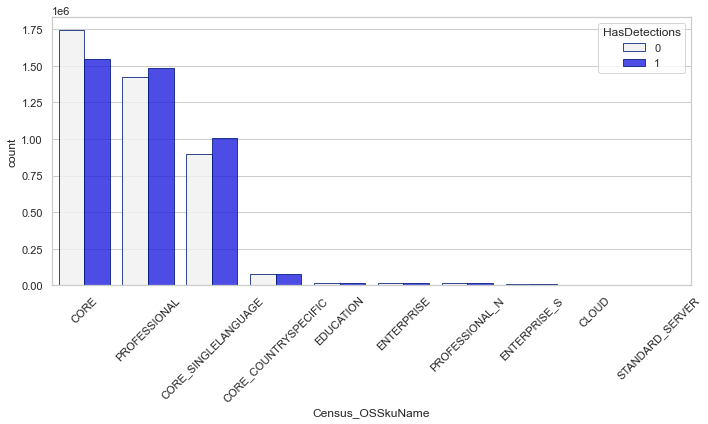

In [102]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Census_OSSkuName',
            hue='HasDetections',
            data=clean_df,
            order = clean_df['Census_OSSkuName'].value_counts().index[:10],
            color='blue',
            edgecolor=sns.color_palette('dark', 1),
            alpha=0.8)
plt.legend(loc=1, title='HasDetections')
plt.xticks(rotation = 45)
plt.tight_layout()

In [103]:
clean_df['Census_OSSkuName'].dtype

CategoricalDtype(categories=['CLOUD', 'CORE', 'CORE_COUNTRYSPECIFIC', 'CORE_N',
                  'CORE_SINGLELANGUAGE', 'EDUCATION', 'EDUCATION_N',
                  'ENTERPRISE', 'ENTERPRISE_S', 'ENTERPRISE_S_N',
                  'PROFESSIONAL', 'PROFESSIONAL_N',
                  'STANDARD_EVALUATION_SERVER', 'STANDARD_SERVER',
                  'DATACENTER_EVALUATION_SERVER', 'SB_SOLUTION_SERVER',
                  'ENTERPRISE_N', 'PRO_WORKSTATION_N', 'PRO_WORKSTATION',
                  'UNLICENSED', 'ULTIMATE', 'CLOUDN', 'PRO_CHINA',
                  'SERVERRDSH', 'DATACENTER_SERVER', 'ENTERPRISEG', 'STARTER',
                  'PRO_FOR_EDUCATION', 'PRO_SINGLE_LANGUAGE', 'UNDEFINED'],
, ordered=False)

In [104]:
clean_df['Census_OSSkuName'].cat.add_categories('Other', inplace=True)
clean_df.loc[(clean_df['Census_OSSkuName'] != 'CORE') & 
             (clean_df['Census_OSSkuName'] != 'PROFESSIONAL') &
             (clean_df['Census_OSSkuName'] != 'CORE_SINGLELANGUAGE') &
             (clean_df['Census_OSSkuName'] != 'CORE_COUNTRYSPECIFIC') &
             (clean_df['Census_OSSkuName'] != 'EDUCATION') &
             (clean_df['Census_OSSkuName'] != 'ENTERPRISE') &
             (clean_df['Census_OSSkuName'] != 'PROFESSIONAL_N') &
             (clean_df['Census_OSSkuName'] != 'PROFESSIONAL_S'),
             'Census_OSSkuName'] = 'Other'
clean_df['Census_OSSkuName'].cat.remove_unused_categories(inplace=True)
clean_df.rename(columns={'Census_OSSkuName':'Census_OSSkuName_encoded'}, inplace=True)
clean_df['Census_OSSkuName_encoded'].value_counts(normalize=True)

C:\Users\marco\anaconda3\envs\capstone2env\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\marco\anaconda3\envs\capstone2env\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
C:\Users\marco\anaconda3\envs\capstone2env\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

CORE                    0.392070
PROFESSIONAL            0.346458
CORE_SINGLELANGUAGE     0.226460
CORE_COUNTRYSPECIFIC    0.018802
Other                   0.004801
EDUCATION               0.004159
ENTERPRISE              0.004121
PROFESSIONAL_N          0.003128
Name: Census_OSSkuName_encoded, dtype: float64

**AvSigVersion_extracted**

In [105]:
av_sig_ver = pd.concat([clean_df['AvSigVersion_extracted'].value_counts(),
                        clean_df['AvSigVersion_extracted'].value_counts(normalize=True)*100], 
                        axis=1)
av_sig_ver.columns=['Count', '%']
av_sig_ver.head(30)

,Count,%
275,3644610,43.412293
273,3503529,41.731825
271,260795,3.106425
269,207924,2.476659
263,150943,1.797938
267,134920,1.607082
251,89405,1.064936
277,74190,0.883704
237,67742,0.806900
261,47542,0.566290


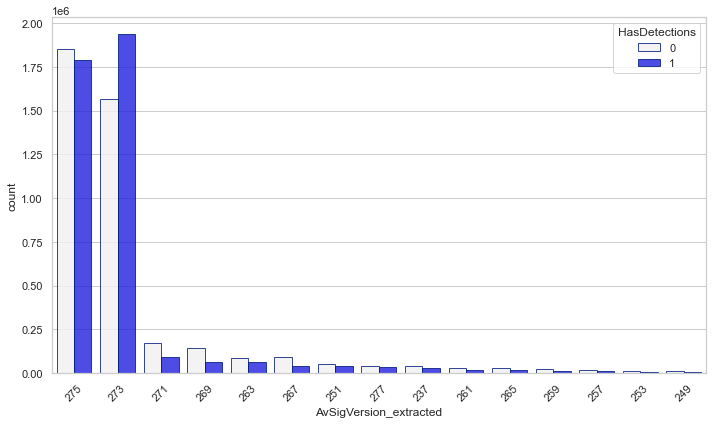

In [106]:
plt.figure(figsize=(10, 6))
sns.countplot(x='AvSigVersion_extracted',
            hue='HasDetections',
            data=clean_df,
            order = clean_df['AvSigVersion_extracted'].value_counts().index[:15],
            color='blue',
            edgecolor=sns.color_palette('dark', 1),
            alpha=0.8)
plt.legend(loc=1, title='HasDetections')
plt.xticks(rotation = 45)
plt.tight_layout()

In [107]:
clean_df['AvSigVersion_extracted'].dtype

CategoricalDtype(categories=['0', '155', '167', '169', '177', '187', '189', '193', '195',
                  '197', '199', '2&#x17;3', '201', '203', '205', '207', '209',
                  '211', '213', '215', '217', '219', '221', '223', '225',
                  '227', '229', '231', '233', '235', '237', '239', '241',
                  '243', '245', '247', '249', '251', '253', '255', '257',
                  '259', '261', '263', '265', '267', '269', '271', '273',
                  '275', '277'],
, ordered=False)

In [108]:
clean_df['AvSigVersion_extracted'] = clean_df['AvSigVersion_extracted'].astype('category')
clean_df['AvSigVersion_extracted'].cat.add_categories('Other', inplace=True)
clean_df.loc[(clean_df['AvSigVersion_extracted'] != '275') & 
             (clean_df['AvSigVersion_extracted'] != '273'),
             'AvSigVersion_extracted'] = 'Other'
clean_df['AvSigVersion_extracted'].cat.remove_unused_categories(inplace=True)
clean_df.rename(columns={'AvSigVersion_extracted':'AvSigVersion_encoded'}, inplace=True)
clean_df['AvSigVersion_encoded'].value_counts(normalize=True)

<ipython-input-108-e7dd5aa7d65b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['AvSigVersion_extracted'] = clean_df['AvSigVersion_extracted'].astype('category')
C:\Users\marco\anaconda3\envs\capstone2env\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\marco\anaconda3\envs\capstone2env\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categori

275      0.434123
273      0.417318
Other    0.148559
Name: AvSigVersion_encoded, dtype: float64

**AppVersion_extracted**

In [109]:
app_ver = pd.concat([clean_df['AppVersion_extracted'].value_counts(),
                        clean_df['AppVersion_extracted'].value_counts(normalize=True)*100], 
                        axis=1)
app_ver.columns=['Count', '%']
app_ver.head(30)

,Count,%
18,5596116,66.657400
12,530454,6.318433
13,482944,5.752524
10,444870,5.299010
9,407054,4.848570
8,269650,3.211901
14,237892,2.833619
16,224987,2.679903
11,196540,2.341060
5,2205,0.026265


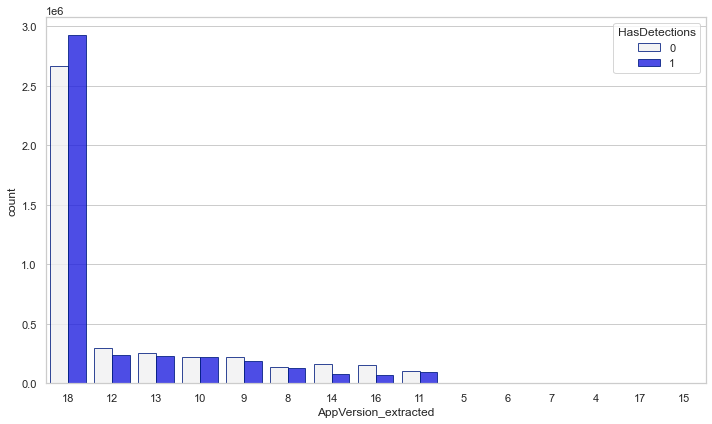

In [110]:
plt.figure(figsize=(10, 6))
sns.countplot(x='AppVersion_extracted',
            hue='HasDetections',
            data=clean_df,
            order = clean_df['AppVersion_extracted'].value_counts().index[:15],
            color='blue',
            edgecolor=sns.color_palette('dark', 1),
            alpha=0.8)
plt.legend(loc=1, title='HasDetections')
plt.tight_layout()

In [111]:
clean_df['AppVersion_extracted'].dtype

CategoricalDtype(categories=['10', '11', '12', '13', '14', '15', '16', '17', '18', '4',
                  '5', '6', '7', '8', '9'],
, ordered=False)

In [112]:
clean_df['AppVersion_extracted'].cat.add_categories('Other', inplace=True)
clean_df.loc[(clean_df['AppVersion_extracted'] != '18') &
             (clean_df['AppVersion_extracted'] != '12') &
             (clean_df['AppVersion_extracted'] != '13') &
             (clean_df['AppVersion_extracted'] != '10') &
             (clean_df['AppVersion_extracted'] != '9') &
             (clean_df['AppVersion_extracted'] != '8') &
             (clean_df['AppVersion_extracted'] != '14') &
             (clean_df['AppVersion_extracted'] != '16') &
             (clean_df['AppVersion_extracted'] != '11'),
             'AppVersion_extracted'] = 'Other'
clean_df['AppVersion_extracted'].cat.remove_unused_categories(inplace=True)
clean_df.rename(columns={'AppVersion_extracted':'AppVersion_encoded'}, inplace=True)
clean_df['AppVersion_encoded'].value_counts(normalize=True)

C:\Users\marco\anaconda3\envs\capstone2env\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\marco\anaconda3\envs\capstone2env\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
C:\Users\marco\anaconda3\envs\capstone2env\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

18       0.666574
12       0.063184
13       0.057525
10       0.052990
9        0.048486
8        0.032119
14       0.028336
16       0.026799
11       0.023411
Other    0.000576
Name: AppVersion_encoded, dtype: float64

**EngineVersion_extracted**

In [113]:
eng_ver = pd.concat([clean_df['EngineVersion_extracted'].value_counts(),
                        clean_df['EngineVersion_extracted'].value_counts(normalize=True)*100], 
                        axis=1)
eng_ver.columns=['Count', '%']
eng_ver.head(30)

,Count,%
15200,3594108,42.810745
15100,3459372,41.205855
15000,259252,3.088046
14901,207487,2.471454
15300,173486,2.066456
14600,150874,1.797116
14800,133541,1.590656
14104,89155,1.061958
13504,67757,0.807079
14700,47909,0.570662


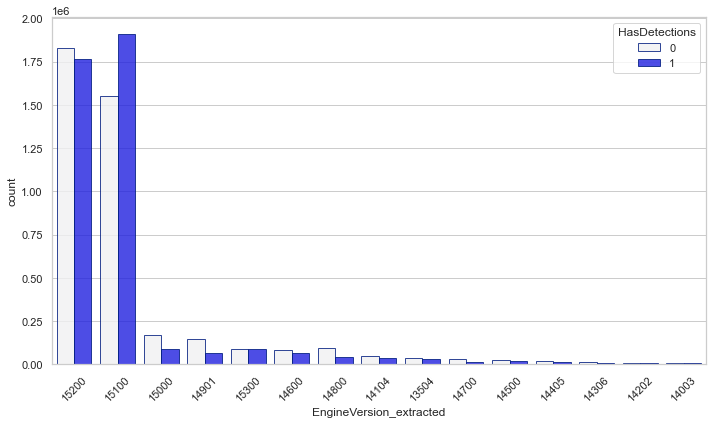

In [114]:
plt.figure(figsize=(10, 6))
sns.countplot(x='EngineVersion_extracted',
            hue='HasDetections',
            data=clean_df,
            order = clean_df['EngineVersion_extracted'].value_counts().index[:15],
            color='blue',
            edgecolor=sns.color_palette('dark', 1),
            alpha=0.8)
plt.legend(loc=1, title='HasDetections')
plt.xticks(rotation = 45)
plt.tight_layout()

In [115]:
clean_df['EngineVersion_extracted'].dtype

CategoricalDtype(categories=['10302', '10401', '10701', '11104', '11202', '11400',
                  '11502', '11602', '11701', '11804', '11903', '12002',
                  '12101', '12205', '12300', '12400', '12505', '12603',
                  '12706', '12802', '12804', '12805', '12902', '13000',
                  '13102', '13103', '13202', '13301', '13303', '13406',
                  '13407', '13503', '13504', '13601', '13701', '13704',
                  '13802', '13803', '13804', '13902', '13903', '14001',
                  '14002', '14003', '14102', '14103', '14104', '14201',
                  '14202', '14303', '14305', '14306', '14405', '14500',
                  '14600', '14700', '14800', '14901', '15000', '15100',
                  '15200', '15300', '9700'],
, ordered=False)

In [116]:
clean_df['EngineVersion_extracted'].cat.add_categories('Other', inplace=True)
clean_df.loc[(clean_df['EngineVersion_extracted'] != '15200') &
             (clean_df['EngineVersion_extracted'] != '15100') &
             (clean_df['EngineVersion_extracted'] != '15000') &
             (clean_df['EngineVersion_extracted'] != '14901') &
             (clean_df['EngineVersion_extracted'] != '15300') &
             (clean_df['EngineVersion_extracted'] != '14600') &
             (clean_df['EngineVersion_extracted'] != '14800') &
             (clean_df['EngineVersion_extracted'] != '14104') &
             (clean_df['EngineVersion_extracted'] != '13504'),
             'EngineVersion_extracted'] = 'Other'
clean_df['EngineVersion_extracted'].cat.remove_unused_categories(inplace=True)
clean_df.rename(columns={'EngineVersion_extracted':'EngineVersion_encoded'}, inplace=True)
clean_df['EngineVersion_encoded'].value_counts(normalize=True)

C:\Users\marco\anaconda3\envs\capstone2env\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\marco\anaconda3\envs\capstone2env\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
C:\Users\marco\anaconda3\envs\capstone2env\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

15200    0.428107
15100    0.412059
Other    0.031006
15000    0.030880
14901    0.024715
15300    0.020665
14600    0.017971
14800    0.015907
14104    0.010620
13504    0.008071
Name: EngineVersion_encoded, dtype: float64

**'Census_OSBranch_release_extracted'**

In [117]:
census_os_release = pd.concat([clean_df['Census_OSBranch_release_extracted'].value_counts(),
                               clean_df['Census_OSBranch_release_extracted'].value_counts(normalize=True)*100],
                               axis=1)
census_os_release.columns=['Count', '%']
census_os_release.head(30)

,Count,%
rs4_release,3586669,42.722243
rs3_release_svc_escrow,1197560,14.264614
rs3_release,1141444,13.596194
rs2_release,748195,8.912049
rs1_release,518263,6.173237
th2_release_sec,273155,3.253658
th1,246384,2.934778
winblue_ltsb_escrow,132992,1.584121
th2_release,124050,1.477609
rs1_release_inmarket,103812,1.236546


In [118]:
clean_df['Census_OSBranch_release_extracted'] = clean_df['Census_OSBranch_release_extracted'].astype('object')
clean_df.loc[clean_df['Census_OSBranch_release_extracted'].str.contains('rs1', na=False, regex=False), 'Census_OSBranch_release_extracted'] = 'rs1_release'
clean_df.loc[clean_df['Census_OSBranch_release_extracted'].str.contains('rs2', na=False, regex=False), 'Census_OSBranch_release_extracted'] = 'rs2_release'
clean_df.loc[clean_df['Census_OSBranch_release_extracted'].str.contains('rs3', na=False, regex=False), 'Census_OSBranch_release_extracted'] = 'rs3_release'
clean_df.loc[clean_df['Census_OSBranch_release_extracted'].str.contains('rs4', na=False, regex=False), 'Census_OSBranch_release_extracted'] = 'rs4_release'
clean_df.loc[clean_df['Census_OSBranch_release_extracted'].str.contains('rs5', na=False, regex=False), 'Census_OSBranch_release_extracted'] = 'rs5_release'
clean_df.loc[clean_df['Census_OSBranch_release_extracted'].str.contains('win', na=False, regex=False), 'Census_OSBranch_release_extracted'] = 'win'
clean_df.loc[clean_df['Census_OSBranch_release_extracted'].str.contains('th2', na=False, regex=False), 'Census_OSBranch_release_extracted'] = 'th'
clean_df.loc[clean_df['Census_OSBranch_release_extracted'].str.contains('th1', na=False, regex=False), 'Census_OSBranch_release_extracted'] = 'th'
clean_df.loc[clean_df['Census_OSBranch_release_extracted'].str.contains('rs_pre', na=False, regex=False), 'Census_OSBranch_release_extracted'] = 'rs_prerelease'

clean_df['Census_OSBranch_release_extracted'].value_counts(normalize=True)

<ipython-input-118-6e6645e0377f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['Census_OSBranch_release_extracted'] = clean_df['Census_OSBranch_release_extracted'].astype('object')
C:\Users\marco\anaconda3\envs\capstone2env\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


rs4_release                  4.272224e-01
rs3_release                  2.847956e-01
rs2_release                  8.912049e-02
rs1_release                  8.394046e-02
th                           7.931883e-02
win                          3.346567e-02
rs5_release                  1.504648e-03
rs_prerelease                6.311850e-04
rs_onecore_stack_per1        1.191140e-07
rs_onecore_base_cobalt       1.191140e-07
rs_xbox                      1.191140e-07
rs_shell                     1.191140e-07
rs6_prerelease               1.191140e-07
rs_onecore_sigma_grfx_dev    1.191140e-07
Name: Census_OSBranch_release_extracted, dtype: float64

In [120]:
other_os_branch = ~clean_df['Census_OSBranch_release_extracted'].isin(['rs4_release',
                                                                       'rs3_release',
                                                                       'rs2_release',
                                                                       'rs1_release',
                                                                       'th'
                                                                       ])
clean_df.loc[other_os_branch, 'Census_OSBranch_release_extracted'] = 'Other'
clean_df.rename(columns={'Census_OSBranch_release_extracted':'Census_OSBranch_release_encoded'}, inplace=True)

clean_df['Census_OSBranch_release_encoded'] = clean_df['Census_OSBranch_release_encoded'].astype('category')
clean_df['Census_OSBranch_release_encoded'].value_counts(normalize=True)

C:\Users\marco\anaconda3\envs\capstone2env\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
<ipython-input-120-0ca451e48ca6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['Census_OSBranch_release_encoded'] = clean_df['Census_OSBranch_release_encoded'].astype('category')


rs4_release    0.427221
rs3_release    0.284795
rs2_release    0.089120
rs1_release    0.083940
th             0.079319
Other          0.035605
Name: Census_OSBranch_release_encoded, dtype: float64

In [121]:
clean_df['Census_OSBranch_release_encoded'].dtype

CategoricalDtype(categories=['Other', 'rs1_release', 'rs2_release', 'rs3_release',
                  'rs4_release', 'th'],
, ordered=False)

**Relationship with target variable**

In [128]:
target_enc_col = mean_encoding_list
cat_col = [col for col in clean_df.select_dtypes('category').columns.tolist() 
           if col not in target_enc_col]
binary_col = clean_df.select_dtypes('Int64').columns.tolist()
num_col = [col for col in clean_df.columns 
           if col not in cat_col
           if col not in target_enc_col
           if col not in binary_col]

len(cat_col), len(target_enc_col), len(binary_col), len(num_col) 

(33, 17, 15, 7)

In [129]:
len(cat_col) + len(target_enc_col) + len(binary_col) + len(num_col)

72

le = preprocessing.LabelEncoder()
chi2_df = clean_df[cat_col + ['HasDetections']].astype('str').dropna().copy()
chi2s = []
pvals = []
chi2s_cont = []
pvals_cont = []

for col in chi2_df.columns:
    chi2_df[col] = le.fit_transform(chi2_df[col])
    chi2_stat, p_val = chi2(chi2_df[col].values.reshape(-1, 1), chi2_df['HasDetections'])
    print(chi2_stat[0], p_val[0])
    chi2s.append(chi2_stat[0])
    pvals.append(p_val[0])
    
    contingency = pd.crosstab(chi2_df[col], chi2_df['HasDetections'])
    chi2_cont, pval_cont, dof, exp = chi2_contingency(contingency)
    chi2s_cont.append(chi2_cont)
    pvals_cont.append(pval_cont)    
    print(chi2, pval)
    

chi2_results = pd.DataFrame({'Chi2':chi2s, 'p-value':pvals}, index=chi2_df.columns)
chi2_results.drop('HasDetections').sort_values('Chi2', ascending=False)

In [131]:
# use contingency as seen in the last row of this notebook

chi2s_cont = []
pvals_cont = []

for col in chi2_df.columns:
    contingency = pd.crosstab(clean_df[col], clean_df['HasDetections'])
    chi2, pval, dof, exp = chi2_contingency(contingency)
    chi2s_cont.append(chi2)
    pvals_cont.append(pval)    

chi2_cont_results = pd.DataFrame({'Chi2':chi2s_cont, 'p-value':pvals_cont}, index=chi2_df.columns)
chi2_cont_results.drop('HasDetections').sort_values('Chi2', ascending=False)

In [135]:
mean_encoding_list

['AVProductStatesIdentifier',
 'CountryIdentifier',
 'CityIdentifier',
 'OrganizationIdentifier',
 'GeoNameIdentifier',
 'LocaleEnglishNameIdentifier',
 'IeVerIdentifier',
 'Census_OEMNameIdentifier',
 'Census_OEMModelIdentifier',
 'Census_ProcessorManufacturerIdentifier',
 'Census_ProcessorModelIdentifier',
 'Census_OSInstallLanguageIdentifier',
 'Census_OSUILocaleIdentifier',
 'Census_FirmwareManufacturerIdentifier',
 'Census_FirmwareVersionIdentifier',
 'Wdft_RegionIdentifier',
 'Census_OSBuildRevision']

## Summary

In [133]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8395341 entries, 0 to 8921482
Data columns (total 72 columns):
 #   Column                                             Dtype   
---  ------                                             -----   
 0   ProductName                                        category
 1   RtpStateBitfield                                   category
 2   IsSxsPassiveMode                                   Int64   
 3   AVProductStatesIdentifier                          category
 4   AVProductsInstalled                                category
 5   AVProductsEnabled                                  category
 6   HasTpm                                             Int64   
 7   CountryIdentifier                                  category
 8   CityIdentifier                                     category
 9   OrganizationIdentifier                             category
 10  GeoNameIdentifier                                  category
 11  LocaleEnglishNameIdentifier          

In [134]:
clean_df.to_pickle('../data/interim/train_clean_roll_up.pickle')